In [1]:
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import os
import time
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Concatenate, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from IPython.display import display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


In [2]:
## ENABLE GPU Acceleration on M2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.17.1
Num GPUs Available:  0


# Constants

In [3]:
rolling_window = 10

dfs_cats = ['reb', 'pts', 'ast', 'stl', 'blk', 'tov']
same_game_cols = ['minutes_played', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb',
                   'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus',
                   'nba_fantasy_pts', 'dd2', 'td3', 'wnba_fantasy_pts', 'available_flag', 'e_off_rating', 'off_rating',
                   'sp_work_off_rating', 'e_def_rating', 'def_rating', 'sp_work_def_rating', 'e_net_rating',
                   'net_rating', 'sp_work_net_rating', 'ast_pct', 'ast_to', 'ast_ratio', 'oreb_pct', 'dreb_pct',
                   'reb_pct', 'tm_tov_pct', 'e_tov_pct', 'efg_pct', 'ts_pct', 'usg_pct_x', 'e_usg_pct', 'e_pace',
                   'pace', 'pace_per40', 'sp_work_pace', 'pie', 'poss', 'fgm_pg', 'fga_pg', 'pct_fga_2pt',
                   'pct_fga_3pt', 'pct_pts_2pt', 'pct_pts_2pt_mr', 'pct_pts_3pt', 'pct_pts_fb', 'pct_pts_ft',
                   'pct_pts_off_tov', 'pct_pts_paint', 'pct_ast_2pm', 'pct_uast_2pm', 'pct_ast_3pm', 'pct_uast_3pm',
                   'pct_ast_fgm', 'pct_uast_fgm', 'pct_fgm', 'pct_fga', 'pct_fg3m', 'pct_fg3a', 'pct_ftm', 'pct_fta',
                   'pct_oreb', 'pct_dreb', 'pct_reb', 'pct_ast', 'pct_tov', 'pct_stl', 'pct_blk', 'pct_blka', 'pct_pf',
                   'pct_pfd', 'pct_pts', 'usage_rate', 'fp_draftkings', 'fp_fanduel',
                   'fp_yahoo']


In [4]:

def assign_league_weeks(df):
    df['week'] = df['game_date'].dt.isocalendar().week
    df['season_start'] = df.groupby('season_year')['game_date'].transform('min')
    df['season_week'] = ((df['game_date'] - df['season_start']).dt.days // 7) + 1
    df = df.drop(columns=['season_start', 'week'])
    df = df.rename(columns={'season_week': 'league_week'})
    return df

In [5]:
def rolling_train_test_rnn(X, y, df, num_weeks_for_training=4, time_steps=4, save_model=False, model_dir='models'):
    os.makedirs(model_dir, exist_ok=True)

    # Initialize lists to store predictions and true values
    all_predictions = []
    all_true_values = []
    all_game_ids = []
    all_game_dates = []
    all_player_ids = []
    all_fanduel_salaries = []
    all_draftkings_salaries = []
    all_yahoo_salaries = []
    all_fanduel_positions = []
    all_draftkings_positions = []
    all_yahoo_positions = []

    scaler = MinMaxScaler(feature_range=(0, 1))
    unique_weeks = df['league_week'].unique()

    for current_week in unique_weeks:
        start_week = current_week - num_weeks_for_training
        training_weeks = list(range(start_week, current_week))

        # Select training data (previous 4 weeks)
        X_train = X[X['league_week'].isin(training_weeks)]
        y_train = y.loc[X_train.index]

        # Select test data (current week)
        X_test = X[X['league_week'] == current_week]
        y_test = y.loc[X_test.index]

        if X_train.empty or X_test.empty:
            continue

        identifying_test_data = X_test[['player_name', 'game_date', 'game_id']]
        X_train = X_train.drop(columns=['game_date', 'game_id'])
        X_test = X_test.drop(columns=['game_date', 'game_id'])

        # Scale data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create sequences for training
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

        # Build and train the RNN model
        model = build_rnn_model((X_train_seq.shape[1], X_train_seq.shape[2]))
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test_seq)

        # Store the predictions and true values
        all_predictions.extend(y_pred.flatten())
        all_true_values.extend(y_test_seq)
        all_game_ids.extend(list(identifying_test_data['game_id'])[time_steps:])
        all_game_dates.extend(list(identifying_test_data['game_date'])[time_steps:])
        all_player_ids.extend(list(identifying_test_data['player_name'])[time_steps:])
        all_fanduel_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_draftkings_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_yahoo_salaries.extend(X_test['salary-yahoo'].values[time_steps:])
        all_fanduel_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_draftkings_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_yahoo_positions.extend(X_test['pos-yahoo'].values[time_steps:])

        if save_model:
            model_filename = f'{model_dir}/rnn_model_week_{current_week}_trained_on_{start_week}_to_{current_week - 1}.h5'
            model.save(model_filename)

        mse = mean_squared_error(y_test_seq, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_seq, y_pred)

        print(f'Training weeks: {training_weeks}')
        print(f'Test week: {current_week}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'R-squared (R²): {r2:.2f}')
        print('')

    results_df = pd.DataFrame({
        'player_name': all_player_ids,
        'game_id': all_game_ids,
        'game_date': all_game_dates,
        'y': all_true_values,
        'y_pred': all_predictions,
        'fanduel_salary': all_fanduel_salaries,
        'draftkings_salary': all_draftkings_salaries,
        'yahoo_salary': all_yahoo_salaries,
        'fanduel_position': all_fanduel_positions,
        'draftkings_position': all_draftkings_positions,
        'yahoo_position': all_yahoo_positions,
    })

    return results_df


In [6]:

def calculate_fp_fanduel(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_yahoo(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_draftkings(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    fp = (row[f'pts{pred}'] +
          row[f'reb{pred}'] * 1.25 +
          row[f'ast{pred}'] * 1.5 +
          row[f'stl{pred}'] * 2 +
          row[f'blk{pred}'] * 2 -
          row[f'tov{pred}'] * 0.5)

    # Calculate Double-Double and Triple-Double bonuses
    stats = [row[f'pts{pred}'], row[f'reb{pred}'], row[f'ast{pred}'], row[f'stl{pred}'], row[f'blk{pred}']]
    double_double = sum([1 for stat in stats if stat >= 10]) >= 2
    triple_double = sum([1 for stat in stats if stat >= 10]) >= 3

    if double_double:
        fp += 1.5
    if triple_double:
        fp += 3

    return fp

def clean_numeric_columns(df, columns):
    """
    Convert columns to numeric, forcing errors to NaN, and handle specific non-numeric values.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN
    return df

def add_time_dependent_features(df, rolling_window):
    for col in same_game_cols:
        logging.info(f"Adding features to {col}")
        gb = df.groupby('player_name')[col]
        df[f'{col}_rolling_{rolling_window}_day_avg'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).mean())
        df[f'{col}_rolling_{rolling_window}_day_std'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).std())
        df[f'{col}_lag_1'] = gb.shift(1)
        df[f'{col}_lag_2'] = gb.shift(2)
        df[f'{col}_lag_3'] = gb.shift(3)
        df[f'{col}_diff_1'] = gb.diff(1)
        df[f'{col}_diff_2'] = gb.diff(2)
        df[f'{col}_diff_3'] = gb.diff(3)
    return df


# Load

In [7]:
df = pd.read_csv('gamelogs_salaries_2022-23_merged.csv')

df = df.drop('Unnamed: 0', axis=1)

<Axes: >

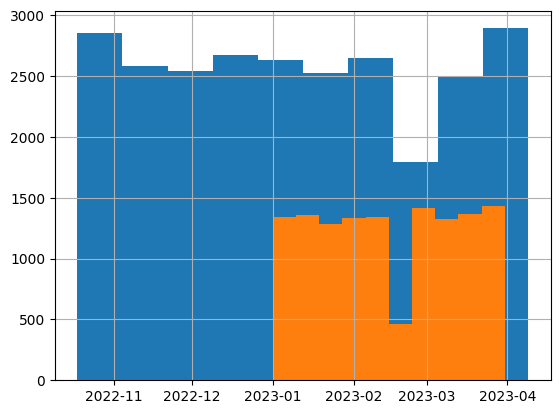

In [8]:
df['game_date'] = pd.to_datetime(df['game_date'])
df['game_date'].hist()
df = add_time_dependent_features(df, rolling_window=10)
df = clean_numeric_columns(df, same_game_cols)

dff = df[(df['game_date'] >= '2023-01-01') & (df['game_date'] < '2023-04-01')]
dff['game_date'].hist()

In [9]:
dff['salary-yahoo'].quantile(0.5)

12.0

In [10]:
dff = dff[(dff['salary-draftkings'] > dff['salary-draftkings'].quantile(0.5)) & (dff['salary-fanduel'] > dff['salary-fanduel'].quantile(0.5)) & (dff['salary-yahoo'] > dff['salary-yahoo'].quantile(0.5))]

In [11]:
dff['game_date'] = pd.to_datetime(dff['game_date'])
metadata = dff[['game_date', 'player_name']].copy()
dff = clean_numeric_columns(dff, same_game_cols)
dff['days_since_start'] = (dff['game_date'] - dff['game_date'].min()).dt.days  # Convert to days
# dff = dff.drop(columns=['game_date'])  # Drop the original 'game_date' column after conversion

## Missing values

In [12]:
len(dff)

5378

In [13]:
# prompt: show only rows and columns with missing values in dff

# Find rows and columns with missing values
rows_with_missing = dff[dff.isnull().any(axis=1)]
cols_with_missing = dff.columns[dff.isnull().any()]

# Show only rows and columns with missing values
dff_missing = dff.loc[dff.isnull().any(axis=1), dff.isnull().any()]

In [14]:
# dff_missing

In [15]:
# rows_with_missing['days_since_start'].value_counts()

Honestly, I have no idea what causes these missing values, so I'm just dropping them

In [16]:
print(len(dff))
dff = dff.dropna()
print(len(dff))


5378
5258


In [17]:
categorical_cols = [col for col in dff.columns if dff[col].dtype == 'object']
dff_encoded = pd.get_dummies(dff, columns=categorical_cols)

In [18]:
dff_encoded

,game_id,game_date,minutes_played,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,...,pos-fanduel_SF/PF,pos-fanduel_SF/SG,pos-fanduel_SG,pos-fanduel_SG/PG,pos-fanduel_SG/SF,pos-yahoo_C,pos-yahoo_PF,pos-yahoo_PG,pos-yahoo_SF,pos-yahoo_SG
1474,22201153,2023-03-31,19.866667,3,6,0.500,0,0,0.000,0,...,False,False,False,False,False,True,False,False,False,False
1481,22201160,2023-03-31,19.700000,3,8,0.375,0,0,0.000,3,...,False,False,False,False,False,True,False,False,False,False
1482,22201149,2023-03-31,29.505000,6,10,0.600,0,3,0.000,2,...,False,True,False,False,False,False,True,False,False,False
1483,22201151,2023-03-31,26.333333,5,11,0.455,1,5,0.200,0,...,False,False,False,False,False,True,False,False,False,False
1488,22201157,2023-03-31,31.100000,6,9,0.667,0,0,0.000,2,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14072,22200549,2023-01-01,32.033333,10,13,0.769,2,2,1.000,8,...,False,False,False,False,False,True,False,False,False,False
14074,22200549,2023-01-01,19.583333,1,6,0.167,0,3,0.000,2,...,False,False,False,False,False,False,False,False,False,True
14078,22200549,2023-01-01,30.100000,3,10,0.300,2,6,0.333,0,...,False,False,False,False,False,True,False,False,False,False
14088,22200549,2023-01-01,32.600000,7,13,0.538,3,7,0.429,2,...,False,False,False,False,False,False,False,False,True,False


In [19]:
print('max: ', dff_encoded['game_date'].max())
print('min: ', dff_encoded['game_date'].min())


max:  2023-03-31 00:00:00
min:  2023-01-01 00:00:00


In [20]:
test_start_date = pd.to_datetime('2023-03-01')
test_end_date = pd.to_datetime('2023-03-28')
sequence_length= 10
epochs = 10
results = []

# Define each weekly start and end date
weekly_periods = pd.date_range(start=test_start_date, end=test_end_date, freq='W-WED')
weekly_periods

DatetimeIndex(['2023-03-01', '2023-03-08', '2023-03-15', '2023-03-22'], dtype='datetime64[ns]', freq='W-WED')

## Model Training Fixed

In [21]:
def create_sequences(data, metadata, sequence_length, target_column):
    sequences, labels, metadata_seq = [], [], []

    # Define columns to drop to avoid leakage
    drop_cols = ['fp_draftkings', 'fp_fanduel', 'fp_yahoo']

    for i in range(sequence_length, len(data)):
        sequence = data.iloc[i - sequence_length:i].drop(columns=drop_cols).values
        label = data.iloc[i][target_column]

        # Track the metadata for this label
        metadata_seq.append(metadata.iloc[i])

        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels), pd.DataFrame(metadata_seq)

In [22]:
import matplotlib.pyplot as plt

def train_and_predict_weekly(
    data,
    metadata,
    target_column,
    sequence_length=10,
    epochs=5,
    lstm_units=100,
    dropout_rate=0.3,
    batch_size=32,
    optimizer='adam',
    validation_split=0.2,
    scaler=StandardScaler,
    test_start_date='2023-03-01',
    test_end_date='2023-03-28',
    train_back_months=2
):
    """
    Train the model weekly, retraining every week with the most recent two months of data.

    Parameters:
    - data: The input DataFrame (encoded features).
    - metadata: DataFrame with 'player_name' and 'game_date' for tracking.
    - target_column: The column to predict (e.g., 'fp_draftkings').
    - sequence_length: The number of previous days to use for training.
    - epochs: Number of epochs to train the model on each window.
    - lstm_units: Number of LSTM units in each layer.
    - dropout_rate: Dropout rate for regularization.
    - batch_size: Batch size for training.
    - optimizer: Optimizer to use (e.g., 'adam', 'rmsprop').
    - validation_split: Fraction of data to use for validation.
    - scaler: Scaler to use (e.g., MinMaxScaler, StandardScaler).
    - test_start_date: Start date for the test period.
    - test_end_date: End date for the test period.
    - train_back_months: Number of months to include in the training period.

    Returns:
    - final_results_df: DataFrame with game_date, player_name, y_test, and y_pred.
    """
    results = []
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    # Define each weekly start and end date
    weekly_periods = pd.date_range(start=test_start_date, end=test_end_date, freq='W-WED')

    for week_start in weekly_periods:
        week_end = week_start + pd.Timedelta(days=6)  # Set test week end to cover 7 days

        # Define training period to be the last two months, ending just before the test week
        train_start_date = week_start - pd.DateOffset(months=train_back_months)
        train_end_date = week_start - pd.Timedelta(days=1)

        # Filter the data for the training and test periods
        train_data = data[(data['game_date'] >= train_start_date) & (data['game_date'] <= train_end_date)]
        test_data = data[(data['game_date'] >= week_start) & (data['game_date'] <= week_end)]
        train_metadata = metadata[(metadata['game_date'] >= train_start_date) & (metadata['game_date'] <= train_end_date)]
        test_metadata = metadata[(metadata['game_date'] >= week_start) & (metadata['game_date'] <= week_end)]

        # Drop date columns from train/test sets for model input
        train_data = train_data.drop(columns=['game_date'])
        test_data = test_data.drop(columns=['game_date'])

        # Create sequences for training and testing
        X_train, y_train, metadata_train = create_sequences(train_data, train_metadata, sequence_length, target_column)
        X_test, y_test, metadata_test = create_sequences(test_data, test_metadata, sequence_length, target_column)

        # Scale the data within this window
        X_train_flat = X_train.reshape(-1, X_train.shape[-1])
        X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
        X_test_flat = X_test.reshape(-1, X_test.shape[-1])
        X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

        # Define the LSTM model with flags
        model = Sequential()
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=lstm_units, return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1))

        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Print the training period for clarity
        print(f"Training for week starting on {week_start.strftime('%Y-%m-%d')} with training period from {train_start_date.strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')} and test period from {week_start.strftime('%Y-%m-%d')} to {week_end.strftime('%Y-%m-%d')}")

        # Train the model
        history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=validation_split)

        # Plot training and validation loss for each week
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss - Week starting {week_start.strftime("%Y-%m-%d")}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Predict for each day in the test period
        y_pred = model.predict(X_test_scaled)

        # Store results
        results_df = pd.DataFrame(metadata_test)
        results_df['y_test'] = y_test.flatten()
        results_df['y_pred'] = y_pred.flatten()
        results.append(results_df)

        print(f"Finished predictions for week ending on {week_end.strftime('%Y-%m-%d')}\n")

    # Concatenate all results into one DataFrame
    final_results_df = pd.concat(results, ignore_index=True)

    return final_results_df

In [23]:
# results_df_agg = train_and_predict_weekly(dff_encoded, metadata, target_column='fp_draftkings', sequence_length=10, epochs=5)

In [24]:
# plt.figure(figsize=(12, 6))
# plt.plot(results_df_agg['y_test'], label='Actual', marker='o', linestyle='-')
# plt.plot(results_df_agg['y_pred'], label='Predicted', marker='x', linestyle='--')
# plt.title(f'Actual vs Predicted Fantasy Points - Week starting {week_start.strftime("%Y-%m-%d")}')
# plt.xlabel('Game Index')
# plt.ylabel('Fantasy Points')
# plt.legend()
# plt.show()


In [ ]:
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler


variations = {
    'sequence_length': [10, 20],
    'epochs': [5, 10],
    'lstm_units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'scaler': [StandardScaler(), MinMaxScaler()]
        }


keys, values = zip(*variations.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

for target_column in ['fp_draftkings', 'fp_fanduel', 'fp_yahoo']:
    print(f"Training model for target column: {target_column}")
    for idx, config in enumerate(configs, start=1):
        print(f"Running configuration {idx}/{len(configs)}: {config}")
        results_df = train_and_predict_weekly(
        data=dff_encoded,
        metadata=metadata,
        target_column=target_column,
        sequence_length=config['sequence_length'],
        epochs=config['epochs'],
        lstm_units=config['lstm_units'],
        dropout_rate=config['dropout_rate'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer'],
        scaler=config['scaler']
            )

        results_df.to_csv(f'results_df_{target_column}_config_{idx}.csv')


In [ ]:
configs